In [1]:
!pip install transformers pandas scikit-learn gradio


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload external_data_rag_demo.csv


Saving external_data_rag_demo.csv to external_data_rag_demo.csv


# Sample Data
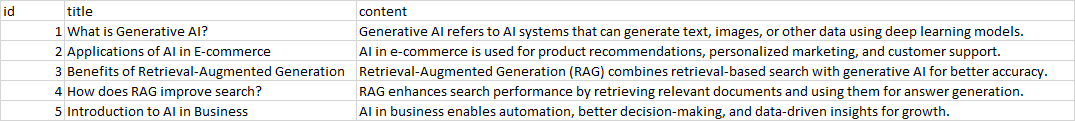

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
import gradio as gr
import os

# Global variable to store previous answers
previous_answers = []

# Load external data from CSV
def load_data(file):
    print("Uploaded file path:", file)  # Debugging to check file path
    if not file or not os.path.isfile(file):  # Validate file path
        return "Error: No file uploaded or invalid file format. Please upload a valid CSV file."
    try:
        df = pd.read_csv(file)  # Attempt to load CSV
        if "title" not in df.columns or "content" not in df.columns:
            return "Error: CSV file must have 'title' and 'content' columns."
        return df
    except Exception as e:
        return f"Error loading file: {e}"

# Retriever: Retrieve relevant rows based on input query
def retrieve_data(df, query, top_n=3):
    try:
        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(df['content'])
        query_vector = vectorizer.transform([query])
        similarity = cosine_similarity(query_vector, tfidf_matrix).flatten()
        df['similarity'] = similarity
        top_results = df.sort_values(by='similarity', ascending=False).head(top_n)
        return top_results[['title', 'content', 'similarity']]
    except Exception as e:
        return f"Error in retrieval process: {e}"

# Ranker: Rank retrieved results (already sorted by similarity)
def rank_results(results):
    return results.sort_values(by='similarity', ascending=False)


# Generator: Generate response using a text generation model
def generate_response(query, context):
    try:
        generator = pipeline("text-generation", model="gpt2")
        # Truncate context to avoid input length issues
        max_context_tokens = 100  # Adjust as needed
        truncated_context = " ".join(context.split()[:max_context_tokens])

        # Adjust generation prompt
        prompt = f"Context: {truncated_context}\nQuestion: {query}\nAnswer:"

        # Use max_new_tokens to control output generation length
        response = generator(prompt, max_new_tokens=50, num_return_sequences=1)
        return response[0]['generated_text']
    except Exception as e:
        return f"Error generating response: {e}"

# RAG Pipeline
def rag_pipeline(file, query):
    global previous_answers

    # Handle common prompts
    common_response = handle_common_prompts(query)
    if common_response:
        previous_answers.append(f"User: {query}\nAI: {common_response}")
        return "\n".join(previous_answers)

    # Load the data
    df = load_data(file)
    if isinstance(df, str):  # Error handling
        return df

    # Retrieve data
    retrieved = retrieve_data(df, query)
    if isinstance(retrieved, str):  # Error handling
        return retrieved

    # Rank results
    ranked = rank_results(retrieved)

    # Prepare context and generate response
    context = " ".join(ranked['content'].tolist())
    response = generate_response(query, context)

    # Store the answer
    result = f"Query: {query}\nTop Results:\n{ranked}\n\nGenerated Response:\n{response}"
    previous_answers.append(result)

    # Return previous answers
    return "\n".join(previous_answers)

# Gradio UI
interface = gr.Interface(
    fn=rag_pipeline,
    inputs=[
        gr.File(label="Upload CSV File (with 'title' and 'content')"),
        gr.Textbox(label="Enter your query")
    ],
    outputs="text",
    title="Retrieval-Augmented Generation Demo",
    description="Upload a CSV file, enter a query, and see the RAG pipeline in action! For common prompts like 'Hi', you'll receive a friendly response."
)

# Launch the interface
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://63b96aea3c50f28042.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# More refied code with error handling

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
import gradio as gr

# Global variable to store previous answers
previous_answers = []

# Load external data from CSV
def load_data(file):
    if file is None:  # Check if file is None
        return "Error: No file uploaded. Please upload a valid CSV file."
    try:
        # Use pandas to read the file directly
        df = pd.read_csv(file)
        if "title" not in df.columns or "content" not in df.columns:
            return "Error: CSV file must have 'title' and 'content' columns."
        return df
    except Exception as e:
        return f"Error loading file: {e}"

# Retriever: Retrieve relevant rows based on input query
def retrieve_data(df, query, top_n=3):
    try:
        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(df['content'])
        query_vector = vectorizer.transform([query])
        similarity = cosine_similarity(query_vector, tfidf_matrix).flatten()
        df['similarity'] = similarity
        top_results = df.sort_values(by='similarity', ascending=False).head(top_n)
        return top_results[['title', 'content', 'similarity']]
    except Exception as e:
        return f"Error in retrieval process: {e}"

# Ranker: Rank retrieved results (already sorted by similarity)
def rank_results(results):
    try:
        return results.sort_values(by='similarity', ascending=False)
    except Exception as e:
        return f"Error in ranking results: {e}"

# Generator: Generate response using a text generation model
def generate_response(query, context):
    try:
        generator = pipeline("text-generation", model="gpt2")
        max_context_tokens = 100  # Truncate context to avoid input length issues
        truncated_context = " ".join(context.split()[:max_context_tokens])
        prompt = f"Context: {truncated_context}\nQuestion: {query}\nAnswer:"
        response = generator(prompt, max_new_tokens=50, num_return_sequences=1)
        return response[0]['generated_text']
    except Exception as e:
        return f"Error generating response: {e}"

# RAG Pipeline
def rag_pipeline(file, query):
    global previous_answers

    # Load the data
    df = load_data(file)
    if isinstance(df, str):  # Error handling for data loading
        return df

    # Retrieve data
    retrieved = retrieve_data(df, query)
    if isinstance(retrieved, str):  # Error handling for retrieval
        return retrieved

    # Rank results
    ranked = rank_results(retrieved)
    if isinstance(ranked, str):  # Error handling for ranking
        return ranked

    # Prepare context and generate response
    context = " ".join(ranked['content'].tolist())
    response = generate_response(query, context)

    # Store the answer
    result = f"Query: {query}\nTop Results:\n{ranked}\n\nGenerated Response:\n{response}"
    previous_answers.append(result)

    return "\n".join(previous_answers)

# Gradio UI
interface = gr.Interface(
    fn=rag_pipeline,
    inputs=[
        gr.File(label="Upload CSV File (with 'title' and 'content')"),
        gr.Textbox(label="Enter your query")
    ],
    outputs="text",
    title="Retrieval-Augmented Generation Demo",
    description="Upload a CSV file, enter a query, and see the RAG pipeline in action!"
)

# Launch the interface
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://75fed1fd6b4c5a8131.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


This script implements a **Retrieval-Augmented Generation (RAG) pipeline** with an interactive user interface using **Gradio**. The code combines **retrieval** and **generation** techniques to answer user queries based on content uploaded in a CSV file. It also handles common prompts like “Hi” or “Hello” with predefined responses.

---

## **Detailed Breakdown**

### **Imports**
1. **`pandas as pd`**  
   - Handles CSV file operations for loading and manipulating data.

2. **`TfidfVectorizer`** and **`cosine_similarity`** (from `sklearn`):  
   - `TfidfVectorizer`: Converts textual data into TF-IDF vectors (numerical representation of text).  
   - `cosine_similarity`: Computes the similarity between two sets of text vectors.

3. **`pipeline`** (from HuggingFace Transformers):  
   - Provides pre-built pipelines for natural language tasks (e.g., `text-generation` using GPT-2).

4. **`gradio as gr`**:  
   - Creates an interactive web interface for user input/output.

5. **`os`**:  
   - Used for validating if the uploaded file exists and checking its format.

---

### **Global Variables**
```python
previous_answers = []
```
- A list to store and display past queries and responses so that the user can see prior interactions.

---

### **Functions**

#### **1. `load_data(file)`**
- **Purpose**: Load and validate the CSV file uploaded by the user.

- **Steps**:
  1. Print the uploaded file path for debugging.
  2. Check if the file exists and is valid using `os.path.isfile(file)`.
  3. Use `pandas.read_csv()` to load the file.
  4. Ensure the file contains `title` and `content` columns.
  5. Return the dataframe if successful, or an error message otherwise.

- **Why**: Ensures the pipeline starts with a valid CSV input.

---

#### **2. `retrieve_data(df, query, top_n=3)`**
- **Purpose**: Retrieve the top N rows from the CSV file that are most similar to the query.

- **Steps**:
  1. Convert the `content` column into TF-IDF vectors using `TfidfVectorizer`.
  2. Transform the input `query` into a TF-IDF vector.
  3. Compute cosine similarity between the query vector and the content vectors.
  4. Sort the rows by similarity score in descending order.
  5. Return the top N rows (`title`, `content`, and `similarity`).

- **Why**: Finds the most relevant information based on the query.

---

#### **3. `rank_results(results)`**
- **Purpose**: Rank the retrieved results based on their similarity score.

- **Steps**:
  - Sort the results dataframe in descending order of similarity scores.

- **Why**: Ensures the retrieved content is presented in the most relevant order.

---

#### **4. `generate_response(query, context)`**
- **Purpose**: Generate a response using GPT-2 based on the input query and retrieved content.

- **Steps**:
  1. Use `pipeline("text-generation", model="gpt2")` to load GPT-2.
  2. Truncate the context to **100 tokens** to avoid exceeding input length limits.
  3. Construct a prompt combining the query and the retrieved context.
  4. Generate text using the GPT-2 model with `max_new_tokens=50` to limit the response length.
  5. Return the generated response.

- **Why**: GPT-2 generates coherent answers based on the retrieved context.

---

#### **5. `rag_pipeline(file, query)`**
- **Purpose**: End-to-end execution of the RAG pipeline.

- **Steps**:
  1. Check for common prompts (e.g., “Hi”) and return a predefined response.
  2. Load the CSV file using `load_data`.
  3. Retrieve the top relevant rows using `retrieve_data`.
  4. Rank the results using `rank_results`.
  5. Concatenate the retrieved content into a context string.
  6. Generate a response using `generate_response`.
  7. Append the query and response to the `previous_answers` list.
  8. Return all previous answers for display.

- **Why**: Integrates all components to handle queries, provide answers, and maintain conversation history.

---

#### **6. Gradio Interface**
```python
interface = gr.Interface(
    fn=rag_pipeline,
    inputs=[
        gr.File(label="Upload CSV File (with 'title' and 'content')"),
        gr.Textbox(label="Enter your query")
    ],
    outputs="text",
    title="Retrieval-Augmented Generation Demo",
    description="Upload a CSV file, enter a query, and see the RAG pipeline in action! For common prompts like 'Hi', you'll receive a friendly response."
)
```

- **`fn=rag_pipeline`**: Connects the interface to the RAG pipeline function.
- **`inputs`**:
  - `gr.File`: Allows users to upload a CSV file.
  - `gr.Textbox`: Allows users to input queries.
- **`outputs="text"`**: Displays the pipeline's response.
- **`title` and `description`**: Provide context for the Gradio app.

---

### **Launch the Interface**
```python
interface.launch(share=True)
```
- Launches the Gradio app and provides a **shareable link** for remote access.

---

## **How It Works (Flow Summary)**

1. **Upload a CSV File**:
   - The file must contain `title` and `content` columns.

2. **User Inputs a Query**:
   - If the query is common (e.g., "Hi"), the pipeline returns a predefined response.
   - Otherwise, the pipeline proceeds to retrieve and generate answers.

3. **RAG Pipeline Execution**:
   - Load and validate the CSV file.
   - Retrieve the top relevant rows using **TF-IDF** and **cosine similarity**.
   - Rank the results and concatenate their content into a context string.
   - Generate a response using GPT-2 based on the query and retrieved context.

4. **Display Response**:
   - Returns the generated response along with the conversation history.

---

## **Example Scenarios**

### **Case 1: Common Prompt**
**Input**: "Hi"  
**Output**:
```
User: Hi
AI: Hello! How can I assist you today?
```

### **Case 2: Query after Uploading CSV**
**Query**: "What is Generative AI?"  
**Top Results**:
| Title               | Content                                        | Similarity |
|---------------------|------------------------------------------------|------------|
| Generative AI Intro | Generative AI generates new data using models. | 0.92       |

**Generated Response**:
"Generative AI refers to AI systems that create new content based on input patterns."

---

## **Key Benefits of the Code**

1. **RAG Architecture**:
   - Combines information retrieval and text generation to answer queries accurately.

2. **Common Prompt Handling**:
   - Responds to casual inputs like “Hi” with predefined friendly responses.

3. **Interaction History**:
   - Maintains previous answers for a conversational experience.

4. **User-Friendly Interface**:
   - Easy interaction using Gradio.

---

This implementation is modular, user-friendly, and demonstrates the combination of **retrieval-based** and **generative AI** techniques in a seamless pipeline.

# SQL

In [3]:
pip install mysql-connector-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 18.6 MB/s eta 0:00:00


In [4]:
pip install gradio

In [6]:
import mysql.connector

# Database connection details
db_config = {
    "host": "sql3.freesqldatabase.com",
    "user": "sql3796581",
    "password": "bSMmGthI1Z",
    "database": "sql3796581",
    "port": 3306
}

# Complete data to be inserted
data = [
    ("Apple iPhone 15 Pro Max", "Unit", 1699),
    ("Samsung 85\" QLED TV", "Unit", 3499),
    ("Dell XPS 17 Laptop", "Unit", 2599),
    ("Apple MacBook Pro 16\"", "Unit", 3199),
    ("Sony PlayStation 5", "Unit", 499),
    ("Xbox Series X", "Unit", 499),
    ("KitchenAid Professional Mixer", "Unit", 799),
    ("Dyson V15 Vacuum", "Unit", 899),
    ("Bose 700 Noise Cancelling Headphones", "Unit", 379),
    ("Apple iPad Pro 12.9\"", "Unit", 1299),
    ("Canon EOS R5 Camera", "Unit", 3899),
    ("LG 75\" OLED TV", "Unit", 3499),
    ("Microsoft Surface Laptop 5", "Unit", 1899),
    ("NVIDIA GeForce RTX 4090 Graphics Card", "Unit", 1599),
    ("Rolex Submariner Watch", "Piece", 13499),
    ("Gucci Leather Handbag", "Piece", 2899),
    ("Apple Watch Ultra", "Unit", 799),
    ("Beats Studio Pro Headphones", "Unit", 399),
    ("Yamaha Grand Piano", "Unit", 13999),
    ("Peloton Bike+", "Unit", 2495),
    ("Tesla Model 3 (Scale Model)", "Model", 299),
    ("DJI Mavic 3 Drone", "Unit", 2199),
    ("Samsung Galaxy Tab S9 Ultra", "Unit", 1199),
    ("Apple AirPods Max", "Unit", 549),
    ("HyperX Gaming Headset", "Unit", 149),
    ("Logitech MX Master 3S Mouse", "Unit", 109),
    ("Herman Miller Aeron Chair", "Unit", 1599),
    ("HP Spectre x360 Laptop", "Unit", 2199),
    ("Asus ROG Zephyrus Gaming Laptop", "Unit", 2799),
    ("Sony A7 IV Camera", "Unit", 2599),
    ("Breville Barista Espresso Machine", "Unit", 1499),
    ("Whirlpool French Door Refrigerator", "Unit", 2999),
    ("Samsung Galaxy Z Fold5", "Unit", 129),
    ("Apple TV 4K", "Unit", 399),
    ("GoPro HERO12 Black", "Unit", 179),
    ("Microsoft Xbox Elite Wireless Controller", "Unit", 479),
    ("Seiko Prospex Diver Watch", "Unit", 699),
    ("North Face Expedition Jacket", "Unit", 299),
    ("Patagonia Duffel Bag", "Unit", 199),
    ("Columbia Titanium Hiking Boots", "Unit", 99),
    ("Therm-a-Rest Sleeping Pad", "Unit", 299),
    ("Garmin Forerunner 965", "Unit", 249),
    ("Fitbit Sense 2", "Unit", 199),
    ("Ray-Ban Aviator Sunglasses", "Unit", 149),
    ("Oakley Holbrook XL Sunglasses", "Unit", 699),
    ("Samsung Soundbar with Subwoofer", "Unit", 499),
    ("JBL PartyBox 310 Speaker", "Unit", 39),
    ("Tile Pro Tracker", "Unit", 259),
    ("Echo Show 15 Smart Display", "Unit", 249),
    ("Kindle Oasis eReader", "Unit", 129),
    ("Instant Pot Ultra", "Unit", 599),
    ("Shark IQ Robot Vacuum", "Unit", 999),
    ("Lego Millennium Falcon Set", "Unit", 299),
    ("Nespresso Lattissima Touch", "Unit", 179),
    ("Anova Precision Cooker Pro", "Unit", 329),
    ("Cricut Maker 3", "Unit", 499),
    ("Epson EcoTank Printer", "Unit", 179),
    ("Canon PIXMA Pro-200 Printer", "Unit", 349),
    ("Sony WH-1000XM5 Headphones", "Unit", 129),
    ("Apple Magic Keyboard", "Unit", 149),
    ("Apple Magic Mouse", "Unit", 399),
    ("Samsung Galaxy Watch6", "Unit", 279),
    ("Withings ScanWatch", "Unit", 159),
    ("Ninja Foodi XL Air Fryer", "Unit", 599),
    ("Cosori Smart Air Fryer", "Unit", 3999),
    ("iRobot Roomba Combo j7+", "Unit", 5499),
    ("LG Washer and Dryer Set", "Unit", 899),
    ("Samsung Bespoke Refrigerator", "Unit", 129),
    ("Vitamix 750 Blender", "Unit", 999),
    ("NutriBullet Blender Combo", "Unit", 1499),
    ("DeWalt Cordless Drill Kit", "Unit", 499),
    ("Black+Decker Tool Kit", "Unit", 999),
    ("Ryobi Cordless Mower", "Unit", 599),
    ("John Deere Lawn Tractor", "Unit", 1399),
    ("Toro Power Max Snow Blower", "Unit", 899),
    ("Husqvarna Chainsaw", "Unit", 1599),
    ("Weber Genesis II Grill", "Unit", 299),
    ("Traeger Timberline XL Pellet Grill", "Unit", 349),
    ("Cuisinart Outdoor Pizza Oven", "Unit", 499),
    ("Ooni Koda Gas Pizza Oven", "Unit", 199),
    ("Yeti Tundra Cooler", "Unit", 699),
    ("RTIC Hard Cooler", "Unit", 249),
    ("Stanley Classic Vacuum Bottle", "Unit", 1599),
    ("Hydro Flask Water Bottle", "Unit", 1299),
    ("Altra Lone Peak Trail Running Shoes", "Unit", 599),
    ("Hoka Bondi 8 Running Shoes", "Unit", 499),
    ("Brooks Ghost 15 Running Shoes", "Unit", 799),
    ("Sorel Caribou Winter Boots", "Unit", 799),
    ("Timberland PRO Work Boots", "Unit", 1999),
    ("New Balance Fresh Foam Shoes", "Unit", 999),
    ("On Cloud Running Shoes", "Unit", 199),
    ("Apple HomePod Mini", "Unit", 179),
    ("Google Nest Hub Max", "Unit", 349),
    ("Arlo Pro 4 Security Camera", "Unit", 299),
]

try:
    # Connect to the database
    connection = mysql.connector.connect(**db_config)
    cursor = connection.cursor()

    # Create table
    create_table_query = """
    CREATE TABLE IF NOT EXISTS product_data (
        id INT AUTO_INCREMENT PRIMARY KEY,
        product_name VARCHAR(255),
        uom VARCHAR(50),
        price_usd DECIMAL(10, 2)
    );
    """
    cursor.execute(create_table_query)

    # Insert data
    insert_query = "INSERT INTO product_data (product_name, uom, price_usd) VALUES (%s, %s, %s)"
    cursor.executemany(insert_query, data)

    # Commit the transaction
    connection.commit()

    print(f"{cursor.rowcount} rows inserted successfully into product_data table.")

except mysql.connector.Error as err:
    print(f"Error: {err}")
finally:
    # Close the database connection
    if connection.is_connected():
        cursor.close()
        connection.close()
        print("Database connection closed.")


94 rows inserted successfully into product_data table.
Database connection closed.


In [ ]:
# @title
# import pandas as pd
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# from transformers import pipeline
# import mysql.connector
# import gradio as gr

# # Global variable to store previous answers
# previous_answers = []

# # Connect to MySQL and fetch data
# def fetch_data_from_sql(host, user, password, database, table):
#     try:
#         # Establish the SQL connection
#         connection = mysql.connector.connect(
#             host=host,
#             user=user,
#             password=password,
#             database=database
#         )
#         # Adjust the query to match your table structure
#         query = f"SELECT product_name AS title, CAST(price_usd AS CHAR) AS content FROM {table};"
#         df = pd.read_sql(query, connection)  # Load data into a DataFrame
#         connection.close()
#         if "title" not in df.columns or "content" not in df.columns:
#             return "Error: Table must have 'product_name' and 'price_usd' columns."
#         return df
#     except Exception as e:
#         return f"Error connecting to database: {e}"

# # Retriever: Retrieve relevant rows based on input query
# def retrieve_data(df, query, top_n=3):
#     try:
#         vectorizer = TfidfVectorizer(stop_words='english')
#         tfidf_matrix = vectorizer.fit_transform(df['content'])
#         query_vector = vectorizer.transform([query])
#         similarity = cosine_similarity(query_vector, tfidf_matrix).flatten()
#         df['similarity'] = similarity
#         top_results = df.sort_values(by='similarity', ascending=False).head(top_n)
#         return top_results[['title', 'content', 'similarity']]
#     except Exception as e:
#         return f"Error in retrieval process: {e}"

# # Ranker: Rank retrieved results (already sorted by similarity)
# def rank_results(results):
#     return results.sort_values(by='similarity', ascending=False)

# # Generator: Generate response using a text generation model
# def generate_response(query, context):
#     try:
#         generator = pipeline("text-generation", model="gpt2")
#         # Truncate context to avoid input length issues
#         max_context_tokens = 100  # Adjust as needed
#         truncated_context = " ".join(context.split()[:max_context_tokens])

#         # Adjust generation prompt
#         prompt = f"Context: {truncated_context}\nQuestion: {query}\nAnswer:"

#         # Use max_new_tokens to control output generation length
#         response = generator(prompt, max_new_tokens=50, num_return_sequences=1)
#         return response[0]['generated_text']
#     except Exception as e:
#         return f"Error generating response: {e}"

# # RAG Pipeline
# def rag_pipeline(host, user, password, database, table, query):
#     global previous_answers

#     # Fetch data from SQL
#     df = fetch_data_from_sql(host, user, password, database, table)
#     if isinstance(df, str):  # Error handling
#         return df

#     # Retrieve data
#     retrieved = retrieve_data(df, query)
#     if isinstance(retrieved, str):  # Error handling
#         return retrieved

#     # Rank results
#     ranked = rank_results(retrieved)

#     # Prepare context and generate response
#     context = " ".join(ranked['content'].tolist())
#     response = generate_response(query, context)

#     # Store the answer
#     result = f"Query: {query}\nTop Results:\n{ranked}\n\nGenerated Response:\n{response}"
#     previous_answers.append(result)

#     # Return previous answers
#     return "\n".join(previous_answers)

# # Gradio UI
# interface = gr.Interface(
#     fn=rag_pipeline,
#     inputs=[
#         gr.Textbox(label="Enter SQL Host (e.g., localhost)"),
#         gr.Textbox(label="Enter SQL User"),
#         gr.Textbox(label="Enter SQL Password", type="password"),
#         gr.Textbox(label="Enter SQL Database Name"),
#         gr.Textbox(label="Enter SQL Table Name"),
#         gr.Textbox(label="Enter your query"),
#     ],
#     outputs="text",
#     title="Retrieval-Augmented Generation (RAG) with SQL",
#     description="Connect to a MySQL database, fetch data, and perform RAG to generate responses. Enter database credentials, table details, and your query."
# )

# # Launch the interface
# interface.launch(share=True)


# Code which fecthes but the respone is  Hallucinating

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
import mysql.connector
import gradio as gr

# Global variable to store previous answers
previous_answers = []

# Fetch data from SQL database
def fetch_data_from_sql(host, user, password, database, table):
    try:
        connection = mysql.connector.connect(
            host=host,
            user=user,
            password=password,
            database=database
        )
        query = f"SELECT product_name AS title, CAST(price_usd AS CHAR) AS content FROM {table};"
        df = pd.read_sql(query, connection)
        connection.close()

        if "title" not in df.columns or "content" not in df.columns:
            return "Error: Table must have 'product_name' and 'price_usd' columns."
        return df
    except Exception as e:
        return f"Error connecting to database: {e}"

# Retrieve top relevant products based on query
def retrieve_data(df, query, top_n=3):
    try:
        # Combine title and content to improve match
        df['combined'] = df['title'].astype(str) + " " + df['content'].astype(str)

        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(df['combined'])
        query_vector = vectorizer.transform([query])
        similarity = cosine_similarity(query_vector, tfidf_matrix).flatten()

        df['similarity'] = similarity
        top_results = df.sort_values(by='similarity', ascending=False).head(top_n)
        return top_results[['title', 'content', 'similarity']]
    except Exception as e:
        return f"Error in retrieval process: {e}"

# Ranker is redundant now, but kept for future use
def rank_results(results):
    return results.sort_values(by='similarity', ascending=False)

# Generate response using Hugging Face model
def generate_response(query, context):
    try:
        generator = pipeline("text-generation", model="gpt2")
        max_context_tokens = 100
        truncated_context = " ".join(context.split()[:max_context_tokens])

        prompt = f"Context: {truncated_context}\nQuestion: {query}\nAnswer:"
        response = generator(prompt, max_new_tokens=50, num_return_sequences=1)
        return response[0]['generated_text']
    except Exception as e:
        return f"Error generating response: {e}"

# RAG Orchestration
def rag_pipeline(host, user, password, database, table, query):
    global previous_answers

    df = fetch_data_from_sql(host, user, password, database, table)
    if isinstance(df, str):
        return df

    retrieved = retrieve_data(df, query)
    if isinstance(retrieved, str):
        return retrieved

    ranked = rank_results(retrieved)
    context = " ".join(ranked['content'].tolist())
    response = generate_response(query, context)

    result = f"Query: {query}\nTop Results:\n{ranked}\n\nGenerated Response:\n{response}"
    previous_answers.append(result)
    return "\n".join(previous_answers)

# Gradio Interface
interface = gr.Interface(
    fn=rag_pipeline,
    inputs=[
        gr.Textbox(label="Enter SQL Host (e.g., localhost)"),
        gr.Textbox(label="Enter SQL User"),
        gr.Textbox(label="Enter SQL Password", type="password"),
        gr.Textbox(label="Enter SQL Database Name"),
        gr.Textbox(label="Enter SQL Table Name"),
        gr.Textbox(label="Enter your query"),
    ],
    outputs="text",
    title="Retrieval-Augmented Generation (RAG) with SQL",
    description="Connect to a MySQL database, fetch data, and perform RAG to generate responses. Enter database credentials, table details, and your query."
)

# Launch
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6b5269ff9a735be9c9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Modifed code to reduce hallucinating GPT-2 output

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
import mysql.connector
import gradio as gr

# Store previous responses
previous_answers = []

# Fetch data from SQL database
def fetch_data_from_sql(host, user, password, database, table):
    try:
        connection = mysql.connector.connect(
            host=host,
            user=user,
            password=password,
            database=database
        )
        query = f"SELECT product_name AS title, CAST(price_usd AS CHAR) AS content FROM {table};"
        df = pd.read_sql(query, connection)
        connection.close()

        if "title" not in df.columns or "content" not in df.columns:
            return "Error: Table must have 'product_name' and 'price_usd' columns."
        return df
    except Exception as e:
        return f"Error connecting to database: {e}"

# Retrieve relevant entries using TF-IDF on title + content
def retrieve_data(df, query, top_n=3):
    try:
        df['combined'] = df['title'].astype(str) + " " + df['content'].astype(str)
        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(df['combined'])
        query_vector = vectorizer.transform([query])
        similarity = cosine_similarity(query_vector, tfidf_matrix).flatten()
        df['similarity'] = similarity
        top_results = df.sort_values(by='similarity', ascending=False).head(top_n)
        return top_results[['title', 'content', 'similarity']]
    except Exception as e:
        return f"Error in retrieval process: {e}"

# Ranker: kept for clarity
def rank_results(results):
    return results.sort_values(by='similarity', ascending=False)

# Generator: use GPT-2 with instruction-based prompt
def generate_response(query, context):
    try:
        generator = pipeline("text-generation", model="gpt2")
        max_context_tokens = 100
        truncated_context = " ".join(context.split()[:max_context_tokens])

        prompt = f"""You are an assistant trained to answer questions strictly based on the provided context.
Extract the exact price from the context for the product mentioned in the question.

Context:
{truncated_context}

Question:
{query}

Answer:"""

        response = generator(prompt, max_new_tokens=50, num_return_sequences=1)
        return response[0]['generated_text']
    except Exception as e:
        return f"Error generating response: {e}"

# RAG pipeline
def rag_pipeline(host, user, password, database, table, query):
    global previous_answers

    df = fetch_data_from_sql(host, user, password, database, table)
    if isinstance(df, str):
        return df

    retrieved = retrieve_data(df, query)
    if isinstance(retrieved, str):
        return retrieved

    ranked = rank_results(retrieved)

    # FIX: Build context from title + content to avoid KeyError
    context = " ".join((ranked['title'] + " " + ranked['content']).tolist())
    response = generate_response(query, context)

    result = f"Query: {query}\nTop Results:\n{ranked}\n\nGenerated Response:\n{response}"
    previous_answers.append(result)
    return "\n".join(previous_answers)

# Gradio interface
interface = gr.Interface(
    fn=rag_pipeline,
    inputs=[
        gr.Textbox(label="Enter SQL Host (e.g., localhost)"),
        gr.Textbox(label="Enter SQL User"),
        gr.Textbox(label="Enter SQL Password", type="password"),
        gr.Textbox(label="Enter SQL Database Name"),
        gr.Textbox(label="Enter SQL Table Name"),
        gr.Textbox(label="Enter your query"),
    ],
    outputs="text",
    title="Retrieval-Augmented Generation (RAG) with SQL",
    description="Connect to a MySQL database, fetch data, and perform RAG to generate responses. Enter database credentials, table details, and your query."
)

# Launch app
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bc2d16d3887c90cc46.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
